In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
import matplotlib.pyplot as plt

In [2]:
merged_data = pd.read_csv('merged_data.csv')

In [3]:
# # Only uncomment this to see feature selection results

# # Filling the null values of fields with the mean value
# features = merged_data.drop(['Date', 'Month', 'index', 'sed'], axis=1).columns

# top_list = ['month', 'Precipitation_average_station_6', 'Precipitation_sum_station_2', 'Precipitation_average_station_3',
#            'Precipitation_sum_station_3', 'Precipitation_sum_station_6', 'Precipitation_average_station_4',
#             'Precipitation_average_station_2', 'Precipitation_average_station_5', 'Precipitation_sum_station_5',
#             'Humidity_average_station_6', 'Humidity_average_station_3', 'Precipitation_sum_station_4', 
#             'Solar_radiation_average_station_3', 'Humidity_average_station_5', 'Precipitation_sum_station_1', 
#             'Humidity_average_station_2', 'Humidity_average_station_1', 'Windspread_average_station_6',
#             'Humidity_average_station_1']
# for feature in features:
#     merged_data[feature] = merged_data[feature].fillna(merged_data[feature].mean())
#     if feature not in top_list:
#         merged_data = merged_data.drop(feature, axis=1)
    


In [4]:
features_ordered_by_pvi = [
    'month',
    'Precipitation_average_station_6',
    'Precipitation_sum_station_2', 
    'Precipitation_average_station_3',
    'Precipitation_sum_station_3', 
    'Precipitation_sum_station_6',
    'Precipitation_average_station_4', 
    'Precipitation_average_station_2',
    'Precipitation_average_station_5', 
    'Precipitation_sum_station_5',
    'Humidity_average_station_6',
    'Humidity_average_station_3',
    'Precipitation_sum_station_4',
    'Solar_radiation_average_station_3',
    'Humidity_average_station_5',
    'Precipitation_sum_station_1',
    'Humidity_average_station_2',
    'Humidity_average_station_1',
    'Windspread_average_station_6',
    'Humidity_average_station_1',
    
    'Humidity_average_station_4',
    'Windspread_average_station_6',
    'Solar_radiation_average_station_4',
    'Tempreture_Min_average_station_3',
    'Solar_radiation_average_station_1',
    'Solar_radiation_average_station_5',
    'Tempreture_Min_average_station_6',
    'Tempreture_Max_average_station_3',
    'Tempreture_Min_average_station_2',
    'Solar_radiation_average_station_6',
    'Tempreture_Min_average_station_1',
    'Windspread_average_station_6',
    'Tempreture_Max_average_station_2',
    'Tempreture_Max_average_station_1',
    'Tempreture_Min_average_station_5',
    'Windspread_average_station_3',
    'Windspread_average_station_5',
    'Tempreture_Max_average_station_5',
    'Tempreture_Max_average_station_4',
    'Windspread_average_station_2',
    'Solar_radiation_average_station_2',
    'Tempreture_Min_average_station_4',
    'Tempreture_Max_average_station_6'
]


In [5]:
# Sort the dataframe by the 'Date' column
merged_data = merged_data.sort_values('Date')

merged_data['month'] = merged_data['Month'].apply(lambda x: int(x.split('-')[1]))

In [6]:
# removing the outlier flows
cleaned_data = merged_data[(merged_data['sed'] <= 4) & (merged_data['sed'] >= 0)]

In [7]:
len(cleaned_data[cleaned_data['sed']<=1])/len(cleaned_data)

0.9644607843137255

## Box Cox 

In [8]:
import pandas as pd
from scipy import stats

# Define the numerical features
numerical_features = cleaned_data.select_dtypes(include=['float64', 'int64']).columns
lambdas = {}

# Apply Box-Cox Transformation
for feature in numerical_features:
    # Shift data to ensure all values are positive if necessary
    min_value = cleaned_data[feature].min()
    shift_value = 1 - min_value + 1e-6  # Add a small constant to ensure no zero values
    cleaned_data[f'{feature}_shifted'] = cleaned_data[feature] + shift_value

    # Apply Box-Cox transformation
    cleaned_data[feature], lambdas[feature] = stats.boxcox(cleaned_data[f'{feature}_shifted'])

    # Drop the shifted column as it's no longer needed
    cleaned_data.drop(f'{feature}_shifted', axis=1, inplace=True)

for feature, lambda_value in lambdas.items():
    print(f'Lambda for {feature}: {lambda_value}')


Lambda for sed: -5.782810361713754
Lambda for index: 0.7097434878697602
Lambda for Precipitation_average_station_1: 0.14346332250356184
Lambda for Precipitation_average_station_2: -0.00602619208114948
Lambda for Precipitation_average_station_3: -0.44447900242181854
Lambda for Precipitation_average_station_4: 0.07764446920893753
Lambda for Precipitation_average_station_5: -0.09593493446001584
Lambda for Precipitation_average_station_6: -0.2503760030045662
Lambda for Precipitation_sum_station_1: 0.3793970375826442
Lambda for Precipitation_sum_station_2: 0.3254827488891362
Lambda for Precipitation_sum_station_3: 0.20468411259760266
Lambda for Precipitation_sum_station_4: 0.3249606359313182
Lambda for Precipitation_sum_station_5: 0.24321697461376066
Lambda for Precipitation_sum_station_6: 0.23011891496555956
Lambda for Humidity_average_station_1: 2.194138793160085
Lambda for Humidity_average_station_2: 1.0545962965101465
Lambda for Humidity_average_station_3: 0.09659705762893364
Lambda for

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Drop non-numeric columns that we won't use in the model
data_model = cleaned_data.drop(columns=['Date', 'Month'])
# data_model = data_model.drop(['Tempreture','Solar radiation', 'Windspread'] , axis=1)

# Define the features (X) and the target variable (y)
X = data_model.drop(['sed'], axis=1)
y = data_model['sed']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=25, random_state=42, max_depth = 15, max_features=15)

# Train the model
rf_regressor.fit(X_train, y_train)

# # Predict on the test set
# y_pred = rf_regressor.predict(X_test)

# Predicting for both training and test sets
y_train_pred = rf_regressor.predict(X_train)
y_test_pred = rf_regressor.predict(X_test)

# Calculate the performance metrics
mse = mean_squared_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)
r2_train = r2_score(y_train, y_train_pred)

mse, r2

# Inspect the maximum depth of the trees
# max_depths = [tree.tree_.max_depth for tree in rf_regressor.estimators_]
# max_depth = max(max_depths)

# print(f"The maximum depth of the trees in the RandomForestRegressor is: {max_depth}")
print(len(X_test))
print(len(y_test_pred))
print(r2)

164
164
0.8037732730837672


## train test predictions with box_cox

In [10]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from scipy import stats
from scipy.special import inv_boxcox

# Assuming cleaned_data is already loaded and prepared

# Ensure 'Date' is a datetime type
cleaned_data['Date'] = pd.to_datetime(cleaned_data['Date'])

# Define the features and target
data_model = cleaned_data.drop(columns=['Date', 'Month'])
features = data_model.drop(['sed', 'index'], axis=1).columns
target = 'sed'

# Split the data into features and target
X = data_model[features]
y = data_model[target]

# Apply Box-Cox transformation to the target
min_value_target = y.min()
shift_value_target = 1 - min_value_target + 1e-6
y_shifted = y + shift_value_target
y_boxcox, lambda_target = stats.boxcox(y_shifted)

# Apply Box-Cox transformation to the features
lambdas_features = {}
for feature in features:
    min_value = X[feature].min()
    shift_value = 1 - min_value + 1e-6
    X[f'{feature}_shifted'] = X[feature] + shift_value
    X[feature], lambdas_features[feature] = stats.boxcox(X[f'{feature}_shifted'])
    X.drop(f'{feature}_shifted', axis=1, inplace=True)

# Initialize the RandomForestRegressor
rf = RandomForestRegressor(n_estimators=25, random_state=42, max_depth=15, max_features=15)

# Set up cross-validation with 5 folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize DataFrames to store the predictions and actuals
train_predictions_df = pd.DataFrame(index=range(len(X)), columns=[f'train{i+1}' for i in range(10)])
test_predictions = np.zeros(len(X))  # Store test predictions

# Initialize lists to store R² score for each fold
r2_train_list = []
r2_test_list = []

# Perform cross-validation
for fold, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y_boxcox[train_index], y_boxcox[test_index]
    
    # Train the model
    rf.fit(X_train, y_train)
    
    # Make predictions for the training and test sets
    train_predictions_boxcox = rf.predict(X_train)
    test_predictions_boxcox = rf.predict(X_test)
    
    # Inverse Box-Cox transformation on the predictions
    train_predictions = inv_boxcox(train_predictions_boxcox, lambda_target) - shift_value_target
    test_predictions_fold = inv_boxcox(test_predictions_boxcox, lambda_target) - shift_value_target
    
    # Store predictions in the DataFrame
    train_predictions_df.iloc[train_index, fold] = train_predictions
    test_predictions[test_index] = test_predictions_fold  # Store all test predictions
    
    # Calculate and store R² score for each fold
    r2_train = r2_score(inv_boxcox(y_train, lambda_target) - shift_value_target, train_predictions)
    r2_test = r2_score(inv_boxcox(y_test, lambda_target) - shift_value_target, test_predictions_fold)
    r2_train_list.append(r2_train)
    r2_test_list.append(r2_test)
    
    # Print performance for this fold
    print(f"Fold {fold + 1} - R² Train: {r2_train:.4f}, R² Test: {r2_test:.4f}")

# Print the average R² score across all folds
print(f"Average R² Train: {np.mean(r2_train_list):.4f}, Average R² Test: {np.mean(r2_test_list):.4f}")

# Calculate the average predictions for the training set
train_predictions_df['avg_train'] = train_predictions_df.mean(axis=1)

# Add the 'Date' and 'Actual' columns
train_predictions_df['Date'] = cleaned_data['Date']
train_predictions_df['Actual'] = cleaned_data['sed']

# Create a DataFrame for test predictions
test_predictions_df = pd.DataFrame({
    'Date': cleaned_data['Date'],
    'Actual': cleaned_data['sed'],
    'Test_Predictions': test_predictions
})

# Reorder columns to have 'Date' first in train_predictions_df
columns = ['Date'] + [f'train{i+1}' for i in range(10)] + ['avg_train', 'Actual']
train_predictions_df = train_predictions_df[columns]

# # Save to Excel
# with pd.ExcelWriter('train_test_predictions_test2.xlsx') as writer:
#     train_predictions_df.to_excel(writer, sheet_name='Train', index=False)
#     test_predictions_df.to_excel(writer, sheet_name='Test', index=False)

print("Predictions with actual data have been saved to train_test_predictions.xlsx")


C:\Users\Ali\AppData\Local\Temp\ipykernel_25732\453090036.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f'{feature}_shifted'] = X[feature] + shift_value
C:\Users\Ali\AppData\Local\Temp\ipykernel_25732\453090036.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature], lambdas_features[feature] = stats.boxcox(X[f'{feature}_shifted'])
C:\Users\Ali\AppData\Local\Temp\ipykernel_25732\453090036.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See 

C:\Users\Ali\AppData\Local\Temp\ipykernel_25732\453090036.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature], lambdas_features[feature] = stats.boxcox(X[f'{feature}_shifted'])
C:\Users\Ali\AppData\Local\Temp\ipykernel_25732\453090036.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(f'{feature}_shifted', axis=1, inplace=True)
C:\Users\Ali\AppData\Local\Temp\ipykernel_25732\453090036.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

Fold 1 - R² Train: 0.9352, R² Test: 0.7646
Fold 2 - R² Train: 0.9326, R² Test: 0.6576
Fold 3 - R² Train: 0.9402, R² Test: 0.7088
Fold 4 - R² Train: 0.9403, R² Test: 0.6661
Fold 5 - R² Train: 0.9400, R² Test: 0.6925
Average R² Train: 0.9376, Average R² Test: 0.6979
Predictions with actual data have been saved to train_test_predictions.xlsx


## OOB Results

In [11]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from scipy import stats
from scipy.special import inv_boxcox

# Assuming cleaned_data is already loaded and prepared

# Ensure 'Date' is a datetime type
cleaned_data['Date'] = pd.to_datetime(cleaned_data['Date'])

# Define the features and target
data_model = cleaned_data.drop(columns=['Date', 'Month'])
features = data_model.drop(['sed', 'index'], axis=1).columns
target = 'sed'

# Split the data into features and target
X = data_model[features]
y = data_model[target]

# Apply Box-Cox transformation to the target
min_value_target = y.min()
shift_value_target = 1 - min_value_target + 1e-6
y_shifted = y + shift_value_target
y_boxcox, lambda_target = stats.boxcox(y_shifted)

# Apply Box-Cox transformation to the features
lambdas_features = {}
for feature in features:
    min_value = X[feature].min()
    shift_value = 1 - min_value + 1e-6
    X[f'{feature}_shifted'] = X[feature] + shift_value
    X[feature], lambdas_features[feature] = stats.boxcox(X[f'{feature}_shifted'])
    X.drop(f'{feature}_shifted', axis=1, inplace=True)

# Initialize the RandomForestRegressor with OOB enabled
rf = RandomForestRegressor(n_estimators=25, random_state=42, max_depth=15, max_features=15 ,oob_score=True)

# Train the model (OOB score will be computed during training)
rf.fit(X, y_boxcox)

# Get the OOB score
oob_score = rf.oob_score_
print(f"OOB Score (R²): {oob_score:.4f}")

# OOB predictions can be accessed through `rf.oob_prediction_`
oob_predictions_boxcox = rf.oob_prediction_

# Inverse Box-Cox transformation on the OOB predictions
oob_predictions = inv_boxcox(oob_predictions_boxcox, lambda_target) - shift_value_target

# Create a DataFrame for OOB predictions and actuals
oob_predictions_df = pd.DataFrame({
    'Date': cleaned_data['Date'],
    'Actual': cleaned_data['sed'],
    'OOB_Predictions': oob_predictions
})

# Reorder columns to have 'Date' first
oob_predictions_df = oob_predictions_df[['Date', 'Actual', 'OOB_Predictions']]

# Optionally, save to Excel
with pd.ExcelWriter('oob_predictions.xlsx') as writer:
    oob_predictions_df.to_excel(writer, sheet_name='OOB_Predictions', index=False)

print("OOB predictions have been saved.")


C:\Users\Ali\AppData\Local\Temp\ipykernel_25732\1842165125.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f'{feature}_shifted'] = X[feature] + shift_value
C:\Users\Ali\AppData\Local\Temp\ipykernel_25732\1842165125.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature], lambdas_features[feature] = stats.boxcox(X[f'{feature}_shifted'])
C:\Users\Ali\AppData\Local\Temp\ipykernel_25732\1842165125.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

S

C:\Users\Ali\AppData\Local\Temp\ipykernel_25732\1842165125.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature], lambdas_features[feature] = stats.boxcox(X[f'{feature}_shifted'])
C:\Users\Ali\AppData\Local\Temp\ipykernel_25732\1842165125.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(f'{feature}_shifted', axis=1, inplace=True)
C:\Users\Ali\AppData\Local\Temp\ipykernel_25732\1842165125.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

OOB Score (R²): 0.7668
OOB predictions have been saved.


## Performance Metrics for Increasing Number of Features

In [12]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import KFold

# Placeholder for results
results = {
    'num_features': [],
    'R2': [],
    'NSE': [],
    'RMSE': [],
    'OOB_Score': []
}

# Function to calculate NSE
def nse(predictions, targets):
    return 1 - (np.sum((predictions - targets) ** 2) / np.sum((targets - np.mean(targets)) ** 2))

# Set up cross-validation with 10 folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Calculate metrics for increasing number of features with cross-validation and OOB
for i in range(1, len(features_ordered_by_pvi) + 1):
    selected_features = features_ordered_by_pvi[:i]
    X = data_model[selected_features]
    y = data_model['sed']
    
    r2_fold = []
    nse_fold = []
    rmse_fold = []
    oob_fold = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Initialize Random Forest with OOB enabled
        rf = RandomForestRegressor(n_estimators=100, oob_score=True, random_state=42)
        rf.fit(X_train, y_train)
        
        # OOB score for the training set
        oob_fold.append(rf.oob_score_)

        # Predictions for test set
        y_pred = rf.predict(X_test)
        
        r2_fold.append(r2_score(y_test, y_pred))
        nse_fold.append(nse(y_pred, y_test))
        rmse_fold.append(mean_squared_error(y_test, y_pred, squared=False))
    
    # Store the average metrics from the cross-validation folds
    results['num_features'].append(i)
    results['R2'].append(np.mean(r2_fold))
    results['NSE'].append(np.mean(nse_fold))
    results['RMSE'].append(np.mean(rmse_fold))
    results['OOB_Score'].append(np.mean(oob_fold))

# Convert results to a DataFrame for easy viewing
results_df = pd.DataFrame(results)

# Save the DataFrame to an Excel file

print("Data has been saved to PVI_feature_metrics.xlsx")

results_df.to_excel('PVI_feature_metrics_have_OOB_2.xlsx', index=False)


Data has been saved to PVI_feature_metrics.xlsx


In [31]:
#cross_validations
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
param_grid = {
    'n_estimators': [25]}

grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
param_grid=param_grid,cv=KFold(n_splits=5, shuffle=True, random_state=42))


grid_search.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestRegressor(random_state=42),
             param_grid={'n_estimators': [25]})

In [32]:
grid_search.cv_results_

{'mean_fit_time': array([0.58487449]),
 'std_fit_time': array([0.00750874]),
 'mean_score_time': array([0.00351429]),
 'std_score_time': array([0.00044808]),
 'param_n_estimators': masked_array(data=[25],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'n_estimators': 25}],
 'split0_test_score': array([0.74776706]),
 'split1_test_score': array([0.77128918]),
 'split2_test_score': array([0.75276325]),
 'split3_test_score': array([0.82232134]),
 'split4_test_score': array([0.70453747]),
 'mean_test_score': array([0.75973566]),
 'std_test_score': array([0.03818155]),
 'rank_test_score': array([1])}

## Best number of trees

In [15]:
Very long runtime

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

# Assuming cleaned_data is already loaded and prepared

# Define the features and target
data_model = cleaned_data.drop(columns=['Date', 'Month'])
features = data_model.drop(['sed', 'index'], axis=1).columns
target = 'sed'

# Split the data into features and target
X = data_model[features]
y = data_model[target]

# Set up cross-validation with 10 folds
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Initialize lists to store the metrics
mae_train_list = []
rmse_train_list = []
mae_test_list = []
rmse_test_list = []
num_trees = range(1, 201)

for n in num_trees:
    rf = RandomForestRegressor(n_estimators=n, random_state=42)
    mae_train_fold = []
    rmse_train_fold = []
    mae_test_fold = []
    rmse_test_fold = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        rf.fit(X_train, y_train)
        
        y_train_pred = rf.predict(X_train)
        y_test_pred = rf.predict(X_test)
        
        mae_train_fold.append(mean_absolute_error(y_train, y_train_pred))
        rmse_train_fold.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
        mae_test_fold.append(mean_absolute_error(y_test, y_test_pred))
        rmse_test_fold.append(np.sqrt(mean_squared_error(y_test, y_test_pred)))
    
    mae_train_list.append(np.mean(mae_train_fold))
    rmse_train_list.append(np.mean(rmse_train_fold))
    mae_test_list.append(np.mean(mae_test_fold))
    rmse_test_list.append(np.mean(rmse_test_fold))

# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'Number_of_Trees': num_trees,
    'MAE_Train': mae_train_list,
    'RMSE_Train': rmse_train_list,
    'MAE_Test': mae_test_list,
    'RMSE_Test': rmse_test_list
})

# Save the DataFrame to an Excel file
# results_df.to_excel('random_forest_metrics_sed_test.xlsx', index=False)

print("Data has been saved to random_forest_metrics.xlsx")



## Best max_depth

In [16]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

# Define the features and target
data_model = cleaned_data.drop(columns=['Date', 'Month'])
features = data_model.drop(['sed', 'index'], axis=1).columns
target = 'sed'

# Split the data into features and target
X = data_model[features]
y = data_model[target]

# Set up cross-validation with 10 folds
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Initialize lists to store the metrics
mae_train_list = []
rmse_train_list = []
mae_test_list = []
rmse_test_list = []

# Range of max_depth values to test
max_depth_values = range(1, 31)  # You can adjust this range as needed

# Fixed number of trees
num_trees = 25  

for depth in max_depth_values:
    rf = RandomForestRegressor(n_estimators=num_trees, max_depth=depth, random_state=42)
    mae_train_fold = []
    rmse_train_fold = []
    mae_test_fold = []
    rmse_test_fold = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        rf.fit(X_train, y_train)

        y_train_pred = rf.predict(X_train)
        y_test_pred = rf.predict(X_test)

        mae_train_fold.append(mean_absolute_error(y_train, y_train_pred))
        rmse_train_fold.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
        mae_test_fold.append(mean_absolute_error(y_test, y_test_pred))
        rmse_test_fold.append(np.sqrt(mean_squared_error(y_test, y_test_pred)))

    mae_train_list.append(np.mean(mae_train_fold))
    rmse_train_list.append(np.mean(rmse_train_fold))
    mae_test_list.append(np.mean(mae_test_fold))
    rmse_test_list.append(np.mean(rmse_test_fold))

# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'Max_Depth': max_depth_values,
    'MAE_Train': mae_train_list,
    'RMSE_Train': rmse_train_list,
    'MAE_Test': mae_test_list,
    'RMSE_Test': rmse_test_list
})

# Save the DataFrame to an Excel file
# results_df.to_excel('random_forest_max_depth_metrics_sediment.xlsx', index=False)

print("Data has been saved to random_forest_max_depth_metrics.xlsx")


Data has been saved to random_forest_max_depth_metrics.xlsx


## Best Max Features

In [17]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold

# Define the features and target
data_model = cleaned_data.drop(columns=['Date', 'Month'])  # Ensure cleaned_data is defined
features = data_model.drop(['sed', 'index'], axis=1).columns
target = 'sed'

# Split the data into features and target
X = data_model[features]
y = data_model[target]

# Set up cross-validation with 10 folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store the metrics
mae_train_list = []
rmse_train_list = []
mae_test_list = []
rmse_test_list = []

# Range of max_features values to test (You can adjust these as needed)
max_features_values = range(1, len(features) + 1)  # Testing from 1 to the total number of features

# Fixed number of trees and max_depth
num_trees = 25  
max_depth = 15

for max_feat in max_features_values:
    rf = RandomForestRegressor(n_estimators=num_trees, max_depth=max_depth, max_features=max_feat, random_state=42)
    mae_train_fold = []
    rmse_train_fold = []
    mae_test_fold = []
    rmse_test_fold = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        rf.fit(X_train, y_train)

        y_train_pred = rf.predict(X_train)
        y_test_pred = rf.predict(X_test)

        mae_train_fold.append(mean_absolute_error(y_train, y_train_pred))
        rmse_train_fold.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
        mae_test_fold.append(mean_absolute_error(y_test, y_test_pred))
        rmse_test_fold.append(np.sqrt(mean_squared_error(y_test, y_test_pred)))

    mae_train_list.append(np.mean(mae_train_fold))
    rmse_train_list.append(np.mean(rmse_train_fold))
    mae_test_list.append(np.mean(mae_test_fold))
    rmse_test_list.append(np.mean(rmse_test_fold))

# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'Max_Features': max_features_values,
    'MAE_Train': mae_train_list,
    'RMSE_Train': rmse_train_list,
    'MAE_Test': mae_test_list,
    'RMSE_Test': rmse_test_list
})

# Save the DataFrame to an Excel file
results_df.to_excel('random_forest_max_features_metrics_sed.xlsx', index=False)

print("Data has been saved to random_forest_max_features_metrics.xlsx")


Data has been saved to random_forest_max_features_metrics.xlsx


In [18]:
from sklearn.metrics import mean_absolute_error

# Calculate MAE
mae_test = mean_absolute_error(y_test, y_test_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)

print("MAE_test:", mae_test)
print("MAE_train:", mae_train)

MAE_test: 0.02141712595155254
MAE_train: 0.007328354615393963


In [19]:
# Calculate RMSE
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))

# Calculate the standard deviation of the observed values
std_dev_test = np.std(y_test)
std_dev_train = np.std(y_train)

# Calculate RSR
rsr_test = rmse_test / std_dev_test
rsr_train = rmse_train / std_dev_train

print("rmse_test:", rmse_test)
print("rmse_train:", rmse_train)

rmse_test: 0.03400718665299166
rmse_train: 0.011776195985392202


In [20]:
# Calculate NSE
nse_test = 1 - np.sum((y_test_pred - y_test) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2)
nse_train = 1 - np.sum((y_train_pred - y_train) ** 2) / np.sum((y_train - np.mean(y_train)) ** 2)

print("NSE_test:", nse_test)
print("NSE_train:", nse_train)

NSE_test: 0.7234939076110412
NSE_train: 0.9628622010970812


## Calculating PVI

In [22]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Assuming X and y are your features and target values

# Initialize the RandomForestRegressor
rf = RandomForestRegressor(n_estimators=25, random_state=42)

# Set up cross-validation with 10 folds
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Initialize DataFrames to store the predictions and actuals
baseline_mae_list = []
permuted_mae_dict = {feature: [] for feature in X.columns}

# Perform cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the model
    rf.fit(X_train, y_train)
    
    # Calculate baseline MAE
    base_mae = mean_absolute_error(y_test, rf.predict(X_test))
    baseline_mae_list.append(base_mae)
    
    # Calculate permuted MAE for each feature
    for feature in X.columns:
        X_test_permuted = X_test.copy()
        X_test_permuted[feature] = np.random.permutation(X_test_permuted[feature].values)
        permuted_mae = mean_absolute_error(y_test, rf.predict(X_test_permuted))
        permuted_mae_dict[feature].append(permuted_mae)

# Calculate average baseline MAE
average_baseline_mae = np.mean(baseline_mae_list)

# Calculate PVI for each feature
pvi_values = {feature: np.mean(permuted_mae_dict[feature]) - average_baseline_mae for feature in X.columns}

# Sorting the dictionary by its values in descending order
sorted_pvi = sorted(pvi_values.items(), key=lambda item: item[1], reverse=True)

# Convert the sorted items back into a dictionary if needed
sorted_pvi = dict(sorted_pvi)

print(len(sorted_pvi))
print(sorted_pvi)


43
{'month': 0.014053725904287172, 'Precipitation_average_station_6': 0.004450183466758434, 'Precipitation_average_station_3': 0.0027847515914458387, 'Precipitation_sum_station_6': 0.002426051914541826, 'Precipitation_sum_station_2': 0.0023972053609780143, 'Precipitation_sum_station_3': 0.0019871448337385085, 'Precipitation_average_station_2': 0.001607158405549293, 'Precipitation_average_station_4': 0.0015682981719206956, 'Humidity_average_station_6': 0.0012918378232842469, 'Precipitation_average_station_5': 0.001256107465350275, 'Precipitation_sum_station_5': 0.0012321028724331107, 'Precipitation_sum_station_4': 0.001012544578275678, 'Humidity_average_station_3': 0.000880104831179028, 'Solar_radiation_average_station_3': 0.0007289542893312087, 'Humidity_average_station_5': 0.0003717112564069376, 'Precipitation_average_station_1': 0.0003690753612919269, 'Precipitation_sum_station_1': 0.0003140756625657215, 'Windspread_average_station_6': 0.00028973823363433876, 'Humidity_average_statio

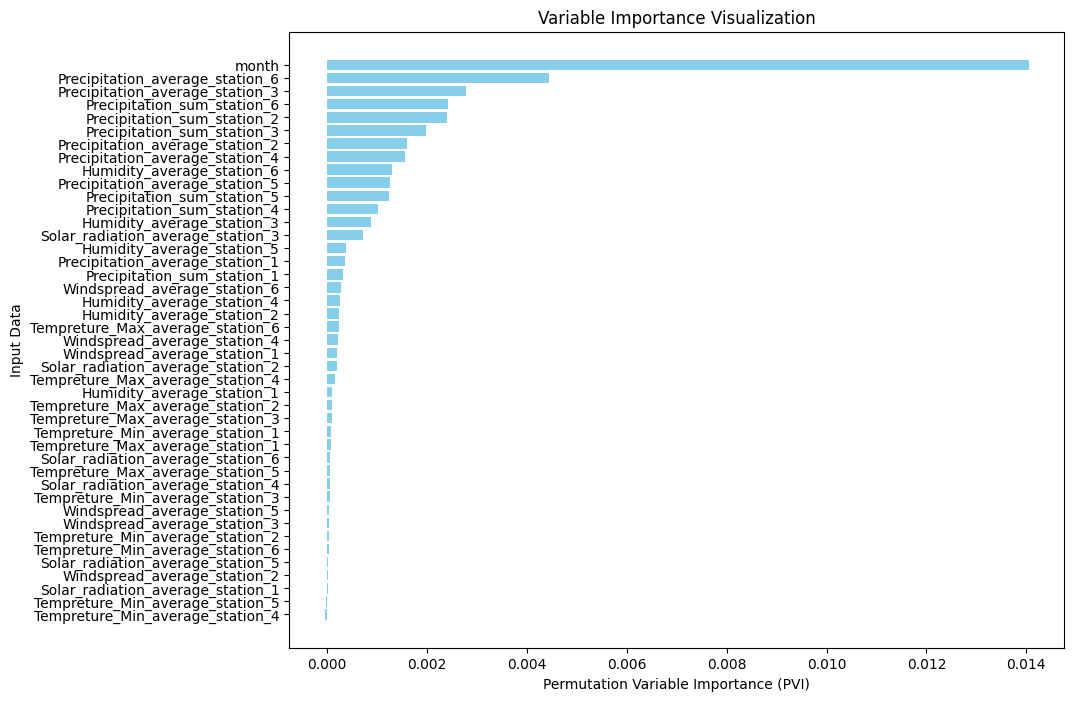

<Figure size 640x480 with 0 Axes>

In [23]:
# Plot the PVI with ranks
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_pvi)), list(sorted_pvi.values()), align='center', color='skyblue')
plt.yticks(range(len(sorted_pvi)), list(sorted_pvi.keys()))
plt.xlabel('Permutation Variable Importance (PVI)')
plt.ylabel('Input Data')
plt.title('Variable Importance Visualization')
plt.gca().invert_yaxis()  # Reverse the order of features
plt.show()
plt.savefig('PVI_sed_test.png')


In [24]:
# # Save to Excel
# pvi_df = pd.DataFrame(list(sorted_pvi.items()), columns=['Feature', 'PVI'])
# pvi_df.to_excel('pvi_values_sed.xlsx', index=False)

## Group PVI 

In [25]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Assuming X and y are your features and target values

# Initialize the RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Set up cross-validation with 10 folds
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Define groups of columns
groups = {
    'Percipitation': ['Precipitation_sum_station_1', 'Precipitation_sum_station_2', 'Precipitation_sum_station_3', 
                      'Precipitation_sum_station_4', 'Precipitation_sum_station_5', 'Precipitation_sum_station_6',
                      'Precipitation_average_station_1', 'Precipitation_average_station_2', 'Precipitation_average_station_3', 
                      'Precipitation_average_station_4', 'Precipitation_average_station_5', 'Precipitation_average_station_6'
                     ],
    'month': ['month'],
    'windspeed': ['Windspread_average_station_1', 'Windspread_average_station_2', 'Windspread_average_station_3', 
                  'Windspread_average_station_4', 'Windspread_average_station_5', 'Windspread_average_station_6'
                 ],
    'Tempreture': ['Tempreture_Max_average_station_1', 'Tempreture_Max_average_station_2', 'Tempreture_Max_average_station_3', 
                   'Tempreture_Max_average_station_4', 'Tempreture_Max_average_station_5', 'Tempreture_Max_average_station_6',
                   'Tempreture_Min_average_station_1', 'Tempreture_Min_average_station_2', 'Tempreture_Min_average_station_3', 
                   'Tempreture_Min_average_station_4', 'Tempreture_Min_average_station_5', 'Tempreture_Min_average_station_6', 
                  ],
    'Solar_radiation': ['Solar_radiation_average_station_1', 'Solar_radiation_average_station_2', 
                       'Solar_radiation_average_station_3', 'Solar_radiation_average_station_4', 
                       'Solar_radiation_average_station_5', 'Solar_radiation_average_station_6'
                       ],
    'Humidity': ['Humidity_average_station_1', 'Humidity_average_station_2', 'Humidity_average_station_3', 
                'Humidity_average_station_4', 'Humidity_average_station_5', 'Humidity_average_station_6'
                ]
}

# Initialize lists to store the baseline and permuted MAE
baseline_mae_list = []
group_permuted_mae_dict = {group: [] for group in groups}

# Perform cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the model
    rf.fit(X_train, y_train)
    
    # Calculate baseline MAE
    base_mae = mean_absolute_error(y_test, rf.predict(X_test))
    baseline_mae_list.append(base_mae)
    
    # Calculate permuted MAE for each group
    for group_name, group_columns in groups.items():
        X_test_permuted = X_test.copy()
        X_test_permuted[group_columns] = X_test_permuted[group_columns].apply(np.random.permutation)
        permuted_mae = mean_absolute_error(y_test, rf.predict(X_test_permuted))
        group_permuted_mae_dict[group_name].append(permuted_mae)

# Calculate average baseline MAE
average_baseline_mae = np.mean(baseline_mae_list)

# Calculate Group PVI for each group
group_pvi_values = {group: np.mean(mae_list) - average_baseline_mae for group, mae_list in group_permuted_mae_dict.items()}

# Sorting the dictionary by its values in descending order
sorted_group_pvi = sorted(group_pvi_values.items(), key=lambda item: item[1], reverse=True)

# Convert the sorted items back into a dictionary if needed
sorted_group_pvi = dict(sorted_group_pvi)

print(len(sorted_group_pvi))
print(sorted_group_pvi)


6
{'Percipitation': 0.023383845356517677, 'month': 0.01518958053133812, 'Humidity': 0.00256667869880077, 'Solar_radiation': 0.001096615834868156, 'windspeed': 0.0008249095901137343, 'Tempreture': 0.00037593385206271396}


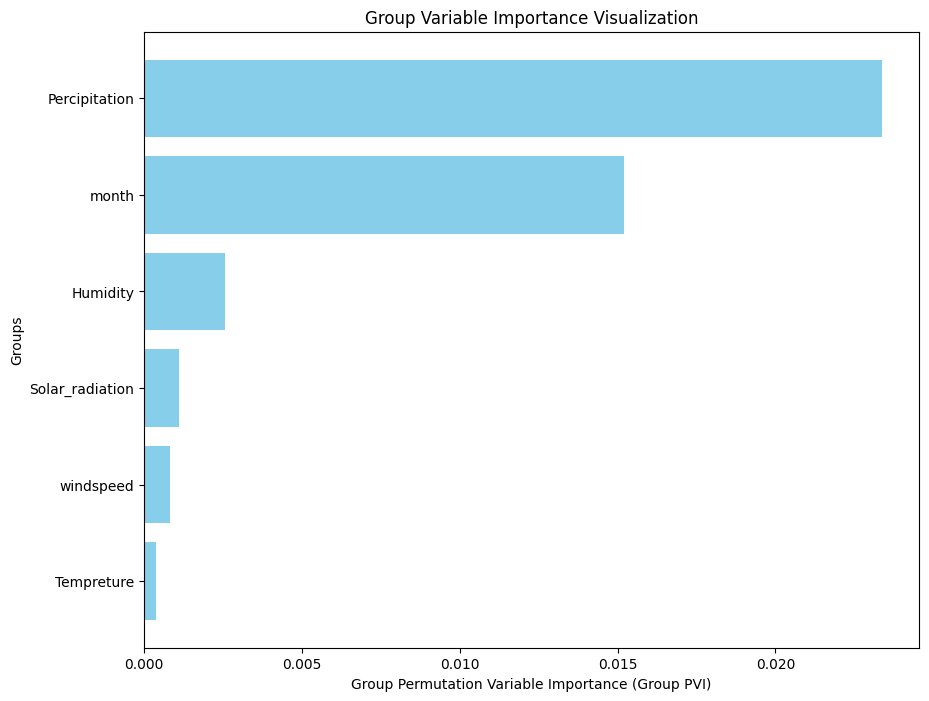

<Figure size 640x480 with 0 Axes>

In [26]:
# Plot the Group PVI
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_group_pvi)), list(sorted_group_pvi.values()), align='center', color='skyblue')
plt.yticks(range(len(sorted_group_pvi)), list(sorted_group_pvi.keys()))
plt.xlabel('Group Permutation Variable Importance (Group PVI)')
plt.ylabel('Groups')
plt.title('Group Variable Importance Visualization')
plt.gca().invert_yaxis()  # Reverse the order of groups
plt.show()
plt.savefig('Group PVI_sed.png', dpi=300, bbox_inches='tight')


In [27]:
# # Save to Excel
# group_pvi_df = pd.DataFrame(list(sorted_group_pvi.items()), columns=['Group', 'Group PVI'])
# group_pvi_df.to_excel('group_pvi_values_sed_test.xlsx', index=False)

## Group PVI by stations

In [28]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Assuming X and y are your features and target values

# Initialize the RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Set up cross-validation with 10 folds
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Define groups of columns
groups = {
    'month': ['month'],
    'station_1': [
        'Precipitation_sum_station_1',
        'Precipitation_average_station_1',
        'Windspread_average_station_1',
        'Tempreture_Max_average_station_1',
        'Tempreture_Min_average_station_1',
        'Solar_radiation_average_station_1',
        'Humidity_average_station_1'
    ],
    'station_2': [
        'Precipitation_sum_station_2',
        'Precipitation_average_station_2',
        'Windspread_average_station_2',
        'Tempreture_Max_average_station_2',
        'Tempreture_Min_average_station_2',
        'Solar_radiation_average_station_2',
        'Humidity_average_station_2'
    ],
    'station_3': [
        'Precipitation_sum_station_3',
        'Precipitation_average_station_3',
        'Windspread_average_station_3',
        'Tempreture_Max_average_station_3',
        'Tempreture_Min_average_station_3',
        'Solar_radiation_average_station_3',
        'Humidity_average_station_3'
    ],
    'station_4': [
        'Precipitation_sum_station_4',
        'Precipitation_average_station_4',
        'Windspread_average_station_4',
        'Tempreture_Max_average_station_4',
        'Tempreture_Min_average_station_4',
        'Solar_radiation_average_station_4',
        'Humidity_average_station_4'
    ],
    'station_5': [
        'Precipitation_sum_station_5',
        'Precipitation_average_station_5',
        'Windspread_average_station_5',
        'Tempreture_Max_average_station_5',
        'Tempreture_Min_average_station_5',
        'Solar_radiation_average_station_5',
        'Humidity_average_station_5'
    ],
    'station_6': [
        'Precipitation_sum_station_6',
        'Precipitation_average_station_6',
        'Windspread_average_station_6',
        'Tempreture_Max_average_station_6',
        'Tempreture_Min_average_station_6',
        'Solar_radiation_average_station_6',
        'Humidity_average_station_6'
    ]
}


# Initialize lists to store the baseline and permuted MAE
baseline_mae_list = []
group_permuted_mae_dict = {group: [] for group in groups}

# Perform cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the model
    rf.fit(X_train, y_train)
    
    # Calculate baseline MAE
    base_mae = mean_absolute_error(y_test, rf.predict(X_test))
    baseline_mae_list.append(base_mae)
    
    # Calculate permuted MAE for each group
    for group_name, group_columns in groups.items():
        X_test_permuted = X_test.copy()
        X_test_permuted[group_columns] = X_test_permuted[group_columns].apply(np.random.permutation)
        permuted_mae = mean_absolute_error(y_test, rf.predict(X_test_permuted))
        group_permuted_mae_dict[group_name].append(permuted_mae)

# Calculate average baseline MAE
average_baseline_mae = np.mean(baseline_mae_list)

# Calculate Group PVI for each group
group_pvi_values = {group: np.mean(mae_list) - average_baseline_mae for group, mae_list in group_permuted_mae_dict.items()}

# Sorting the dictionary by its values in descending order
sorted_group_pvi = sorted(group_pvi_values.items(), key=lambda item: item[1], reverse=True)

# Convert the sorted items back into a dictionary if needed
sorted_group_pvi = dict(sorted_group_pvi)

print(len(sorted_group_pvi))
print(sorted_group_pvi)


7
{'month': 0.013368043549169678, 'station_6': 0.008783162177413248, 'station_3': 0.005813763034926818, 'station_2': 0.0052842453297088365, 'station_5': 0.002922318874338286, 'station_4': 0.0025299191812754238, 'station_1': 0.001255336197692209}


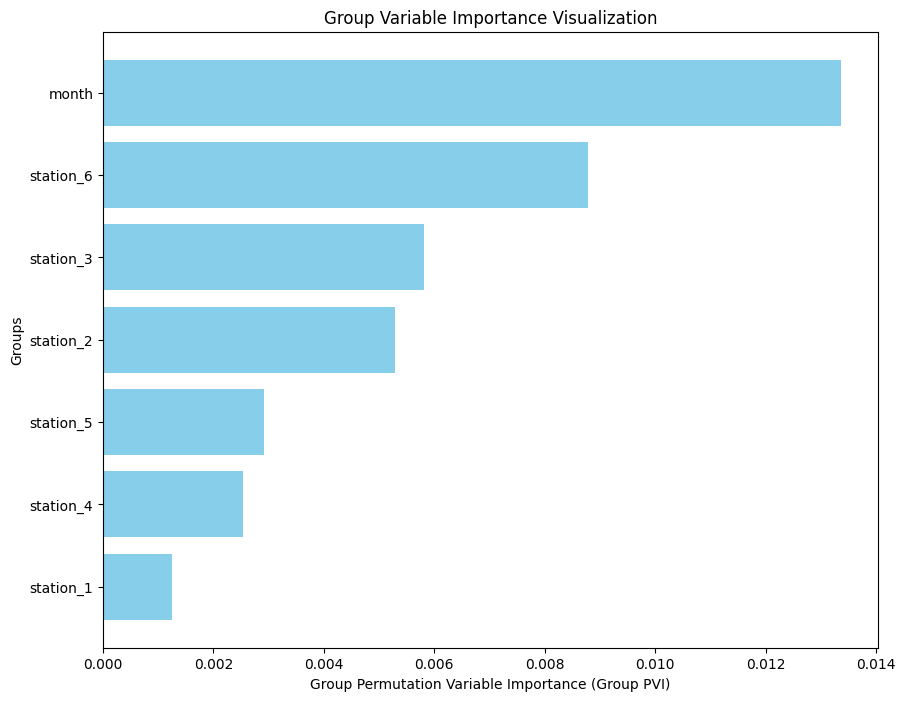

<Figure size 640x480 with 0 Axes>

In [29]:
# Plot the Group PVI
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_group_pvi)), list(sorted_group_pvi.values()), align='center', color='skyblue')
plt.yticks(range(len(sorted_group_pvi)), list(sorted_group_pvi.keys()))
plt.xlabel('Group Permutation Variable Importance (Group PVI)')
plt.ylabel('Groups')
plt.title('Group Variable Importance Visualization')
plt.gca().invert_yaxis()  # Reverse the order of groups
plt.show()
plt.savefig('Group PVI_by_stations.png', dpi=300, bbox_inches='tight')

In [30]:
# Save to Excel
# group_pvi_df = pd.DataFrame(list(sorted_group_pvi.items()), columns=['Group', 'Group PVI'])
# group_pvi_df.to_excel('group_pvi_by_stations_sed.xlsx', index=False)